In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

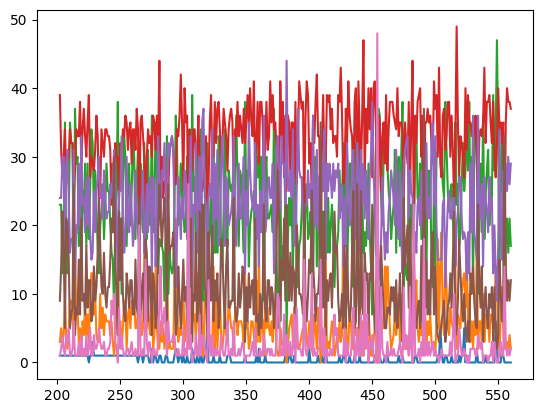

In [2]:
# import raw data and plot
data_set = pd.read_csv('Wordle.csv')
data_x = data_set.loc[:, ['Contest number']].values
data_y = data_set.iloc[:, 5:12].values
plt.plot(data_x, data_y)
plt.show()

In [3]:
data = data_y
data = data.astype('float32')
# print(data)
# normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
# data

[[ 1.  3. 23. ... 24.  9.  1.]
 [ 1.  5. 23. ... 24. 14.  2.]
 [ 1.  3. 13. ... 30. 22.  4.]
 ...
 [ 0.  2. 16. ... 30. 12.  2.]
 [ 0.  4. 21. ... 26.  9.  1.]
 [ 0.  2. 17. ... 29. 12.  2.]]


array([[0.16666667, 0.11538462, 0.4418605 , ..., 0.42857143, 0.20000002,
        0.02083333],
       [0.16666667, 0.1923077 , 0.4418605 , ..., 0.42857143, 0.34285715,
        0.04166667],
       [0.16666667, 0.11538462, 0.20930232, ..., 0.6       , 0.5714286 ,
        0.08333334],
       ...,
       [0.        , 0.07692308, 0.27906978, ..., 0.6       , 0.2857143 ,
        0.04166667],
       [0.        , 0.15384616, 0.39534885, ..., 0.4857143 , 0.20000002,
        0.02083333],
       [0.        , 0.07692308, 0.3023256 , ..., 0.57142854, 0.2857143 ,
        0.04166667]], dtype=float32)

In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [5]:
reframed = series_to_supervised(data, 1, 1)
values = reframed.values
# Slice the test and training sets
train_size = int(len(values) * 0.75)
train = values[:train_size, :]
test = values[train_size:, :]
train_x, train_y = train[:, :-7], train[:, -7:]
test_x, test_y = test[:, :-7], test[:, -7:]

# print out their dimensions
print ('train_x.shape, train_y.shape, test_x.shape, test_y.shape')
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

train_x.shape, train_y.shape, test_x.shape, test_y.shape
(268, 7) (268, 7) (90, 7) (90, 7)


In [6]:
# initialize paraments
inp_dim = 7
out_dim = 7
mid_dim = 8
mid_layers = 1
batch_size = 49
mod_dir = '.'

In [7]:
class RegLSTM(nn.Module):
    def __init__(self, inp_dim, out_dim, mid_dim, mid_layers):
        super(RegLSTM, self).__init__()

        self.rnn = nn.LSTM(inp_dim, mid_dim, mid_layers)  # rnn
        self.reg = nn.Sequential(
            nn.Linear(mid_dim, mid_dim),
            nn.Tanh(),
            nn.Linear(mid_dim, out_dim),
        )  # regression

    def forward(self, x):
        y = self.rnn(x)[0]  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.shape
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y

    def output_y_hc(self, x, hc):
        y, hc = self.rnn(x, hc)  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.size()
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y, hc


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = RegLSTM(inp_dim, out_dim, mid_dim, mid_layers).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

In [8]:
#Slice
var_x = torch.tensor(train_x, dtype=torch.float32, device=device)
var_y = torch.tensor(train_y, dtype=torch.float32, device=device)

batch_var_x = list()
batch_var_y = list()

for i in range(batch_size):
    j = train_size - i
    batch_var_x.append(var_x[j:])
    batch_var_y.append(var_y[j:])

from torch.nn.utils.rnn import pad_sequence

batch_var_x = pad_sequence(batch_var_x)
batch_var_y = pad_sequence(batch_var_y)

with torch.no_grad():
    weights = np.tanh(np.arange(len(train_y)) * (np.e / len(train_y)))
    weights = torch.tensor(weights, dtype=torch.float32, device=device)

In [9]:
np.shape(batch_var_y)

torch.Size([48, 49, 7])

In [10]:
# 切换为训练模式，开始训练LSTM模型
net = net.train()
print("Training Start")
for e in range(1000):
    # 输入数据
    out = net(batch_var_x)
    # 预测值与真实值计算loss
    loss = criterion(out, batch_var_y)
    loss = loss.mean()
    # 优化函数根据loss进行优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 64 == 0:
        print('Epoch: {:4}, Loss: {:.5f}'.format(e, loss.item()))
# 保存整个网络的参数至本地磁盘，评价时可以直接调取参数，无需再次训练
torch.save(net.state_dict(), '{}/net.pth'.format(mod_dir))
print("Save in:", '{}/net.pth'.format(mod_dir))

Training Start
Epoch:    0, Loss: 0.16438
Epoch:   64, Loss: 0.01214
Epoch:  128, Loss: 0.01082
Epoch:  192, Loss: 0.00911
Epoch:  256, Loss: 0.00662
Epoch:  320, Loss: 0.00553
Epoch:  384, Loss: 0.00438
Epoch:  448, Loss: 0.00377
Epoch:  512, Loss: 0.00354
Epoch:  576, Loss: 0.00317
Epoch:  640, Loss: 0.00301
Epoch:  704, Loss: 0.00292
Epoch:  768, Loss: 0.00278
Epoch:  832, Loss: 0.00270
Epoch:  896, Loss: 0.00254
Epoch:  960, Loss: 0.00248
Save in: ./net.pth


In [11]:
# 读取参数，切换到评价模式
net.load_state_dict(torch.load('{}/net.pth'.format(mod_dir), map_location=lambda storage, loc: storage))
net = net.eval()
# 手动设置全部已知数据为初始测试数据，清空测试集部分的数据用作预测，然后在其后面添加60行零向量，预测之后60天的值
test_x = values[:, :-7]
test_x[train_size:, :] = 0
zeros = np.zeros((60, 7))
test_x = np.concatenate((test_x, zeros), axis=0)

test_x = test_x[:, np.newaxis, :]
test_x = torch.tensor(test_x, dtype=torch.float32, device=device)
# 循环调用网络，把每次的预测值放入test_x里面，然后再把test_x作为数据放入网络中，最后预测出后面所有数据
for i in range(train_size, len(test_x)):
    test_y = net(test_x[:i])
    test_x[i] = test_y[-1]

In [12]:
# 反归一化，并且获取预测值，这样输出的就是之前的百分数了，即每一行7个数加起来约等于100
test_x_percent = test_x[:,0,:]
test_x_percent = test_x_percent.cpu().data.numpy()
test_x_percent = scaler.inverse_transform(test_x_percent)
test_x_percent = np.around(test_x_percent)
pred_y = test_x_percent[train_size:]
print(pred_y)
pred_known = pred_y[:len(values)-train_size] # 为测试部分
pred_unknown = pred_y[len(values)-train_size:] # 为预测部分

[[ 0.  7. 28. ... 20.  5. -0.]
 [-0.  4. 20. ... 25. 10.  0.]
 [ 0.  6. 24. ... 22.  8.  1.]
 ...
 [ 0.  2. 16. ... 30. 14.  6.]
 [ 1.  2. 21. ... 26.  8.  0.]
 [ 1. 11. 37. ... 13. -2. -4.]]


([<matplotlib.patches.Wedge at 0x1718db1c488>,
 [Text(2.5987170570082494, 0.08166797177831267, '1 try'),
  Text(1.0095300896839505, 0.4368626763900927, '2 tries'),
  Text(-0.37261172244440205, 1.0349688421865733, '3 tries'),
  Text(-0.4683572109368792, -0.9953097623169522, '4 tries'),
  Text(1.0095300794584414, -0.4368627000198496, '5 tries'),
  Text(1.0999999999999994, -3.862103765980731e-08, '6 tries'),
  Text(2.5999999999999988, -9.128608901409002e-08, '7 or more tries (X)')],
 [Text(2.0989637768143554, 0.06596259259017562, '1.0%'),
  Text(0.5506527761912458, 0.23828873257641417, '11.0%'),
  Text(-0.20324275769694655, 0.5645284593744945, '37.0%'),
  Text(-0.2554675696019341, -0.5428962339910648, '38.0%'),
  Text(0.5506527706136953, -0.2382887454653725, '13.0%'),
  Text(0.5999999999999995, -2.106602054171308e-08, '0.0%'),
  Text(2.0999999999999988, -7.373107189599579e-08, '0.0%')])

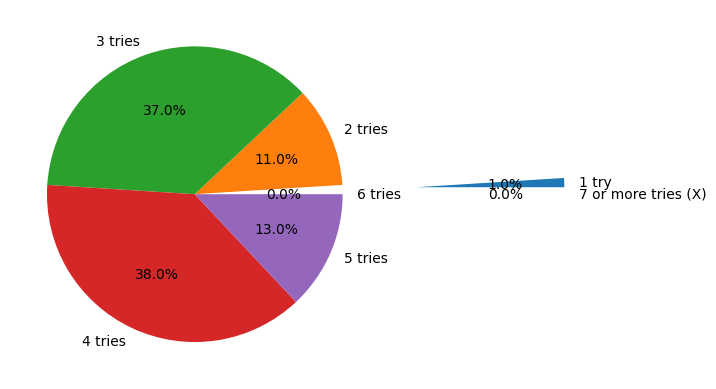

In [13]:
pred_unknown[pred_unknown<0]=0
label=["1 try","2 tries","3 tries","4 tries","5 tries","6 tries","7 or more tries (X)"]
expld=[1.5,0,0,0,0,0,1.5]
plt.pie(pred_unknown[59],explode=expld,labels=label, autopct='%3.1f%%')